In [1]:
# inspired by
# https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier
# http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
# https://www.kaggle.com/b0siangyang/titanic/a-journey-through-titanic-2b4fbb

# remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

pd.options.display.max_rows = 100

import re as re
import matplotlib.pyplot as plt
import bisect
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

floc="./"
# GET DATA
def get_combined_data():
    # reading train data
    train = pd.read_csv(floc+'train.csv')
    
    # reading test data
    test = pd.read_csv(floc+'test.csv')

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop('Survived',1,inplace=True)
    

    # merging train data and test data for future feature engineering
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace=True,axis=1)
    
    return combined

def recover_train_test_target(data_set):
   
    train0 = pd.read_csv(floc+'train.csv')
    
    targets = train0.Survived
    train = data_set.ix[0:890]
    test = data_set.ix[891:]
    
    return train,test,targets

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


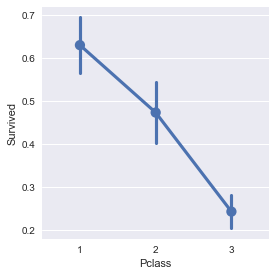

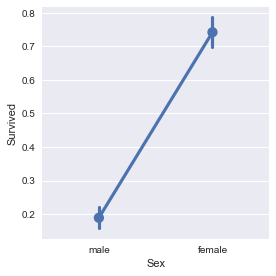

In [2]:
# DATA ANALYSIS - TRUNCATED 
train=pd.read_csv(floc+'train.csv')
train['Embarked'].fillna('S',inplace=True) 
sns.factorplot("Pclass","Survived",data=train)
sns.factorplot("Sex","Survived",data=train)
plt.show()

In [3]:
# GET DATA AND PROCESS
full=get_combined_data()

def process_tickets():
    global full
    
    #TICKET NUMBER
    full.Ticket.fillna("0")
    full["Ticket Number"]=full.Ticket.replace("LINE","-1").map(lambda l: int(l.strip().split()[-1]))
    full["Ticket Letter"]=full.Ticket.map(lambda l: l.strip().split()[0][0])
    def int_filter(li):
        for it in li:
            try:
                int(it)
                yield "N"
            except:
                yield it
    full["Ticket Letter"]=list(int_filter(full["Ticket Letter"].values))
    dummies=pd.get_dummies(full["Ticket Letter"],prefix="Ticket Letter ")
    full=pd.concat([full,dummies],axis=1)
    full.drop("Ticket Letter",axis=1,inplace=True)

process_tickets()    


def process_titles():
    global full
    
    # ADD TITLE DESCRIPTOR
    def get_title(name):
        title_search = re.search(' ([A-Za-z]+)\.', name)
        # If the title exists, extract and return it.
        if title_search:
            return title_search.group(1)
        return ""

    full['Title'] = full['Name'].apply(get_title)   

    full['Title'] = full['Title'].replace(['Capt', 'Col','Major', 'Sir', 'Jonkheer','Dr','Rev'], 'Officer')
    full['Title'] = full['Title'].replace(['Lady', 'Countess','Don','Sir', 'Jonkheer', 'Dona'], 'Royal')

    full['Title'] = full['Title'].replace('Mlle', 'Miss')
    full['Title'] = full['Title'].replace('Ms', 'Miss')
    full['Title'] = full['Title'].replace('Mme', 'Mrs')
    
    # Mapping Name
    full["Name"]=full["Name"].map(lambda x: len(x))
    dummies=pd.get_dummies(full.Title,prefix="Title")
    full=pd.concat([full,dummies],axis=1)
    full.drop("Title",axis=1,inplace=True)   

process_titles()

def process_person():
    global full
    # Mapping Sex
    def get_person(p):
        age,sex=p
        #return "child" if age<16 else sex
        if age<4:
            return "small child"
        elif age<16:
            return "young"
        else:
            return sex
        
    full["Person"]=full[["Age","Sex"]].apply(get_person,axis=1)
    dummies=pd.get_dummies(full["Person"])
    full=full.join(dummies)

# FILL GAPS AND REGULARIZE
def fillgaps(column1,column2):
    global full
    
    """FILL COLUMN2 WITH MOST LIKELY VALUES BASED ON COLUMN1"""
    ddict={}
    d=full[[column1,column2]].dropna().values
    c1=np.array(d[:,0].tolist())
    c2=np.array(d[:,1].tolist())
    for ic1 in np.unique(c1):
        ddict[ic1]=(c2[c1==ic1].mean(),c2[c1==ic1].std())

    for missing in np.where(np.isnan(full[column2]))[0]:
        m,s=ddict[full[column1][missing]]
        full[column2][missing]=np.random.normal(loc=m,scale=s,size=1)

fillgaps("SibSp","Age")
fillgaps("Pclass","Fare")
    
process_person()

def process_cabin():
    global full

    # FIX CABIN
    full.Cabin.fillna('U',inplace=True)

    # replace with prefix
    full.Cabin=full.Cabin.map(lambda cabin: cabin[0])    
    dummies=pd.get_dummies(full.Cabin,prefix="Cabin ")
    full=pd.concat([full,dummies],axis=1)
    full.drop("Cabin",axis=1,inplace=True)

process_cabin()
 
# MAPPING EMBARKED
def process_embarked():
    global full
    #full['Embarked'] = full['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    full['Embarked'].fillna('S',inplace=True)
    dummies=pd.get_dummies(full["Embarked"])
    full=full.join(dummies)
    
process_embarked()

def process_pclass():
    global full
    dummies=pd.get_dummies(full["Pclass"]) #.drop(3,axis=1)
    full=full.join(dummies)
process_pclass()

def process_family():
    global full
    full["Family"]=full['Parch'] + full['SibSp'] + 1
process_family()


# GENERATE BETTER DESCRIPTORS
full["Familial Uniqueness"]= np.exp(-full.Age/5.)/(full['Family'])
full["Detail oriented nature"]=full.Name/(10*full.Sex.map({"male":1,"female":2}))

ms=np.array([full.Fare[full.Pclass==(i+1)].mean() for i in range(3)])
full["Relative Fare"]=full.Fare*(1./full.Pclass)**3/ms[full.Pclass-1]

# CHILDREN TRAVELING ALONE
full["Children alone"]=np.array((full.Parch>0)*(full.Age<18.),dtype=float)

# Elderly
full["Elder"]=np.array((full.Age>70.),dtype=float)

def drop_descriptors():
    global full
    full.drop(["Ticket"],axis=1,inplace=True)
    full.drop(["Pclass"],axis=1,inplace=True)
    full.drop(["Embarked"],axis=1,inplace=True)
    full.drop(["Sex","Person"],axis=1,inplace=True)
    
drop_descriptors()
full.head()

,PassengerId,Name,Age,SibSp,Parch,Fare,Ticket Number,Ticket Letter _A,Ticket Letter _C,Ticket Letter _F,Ticket Letter _L,Ticket Letter _N,Ticket Letter _P,Ticket Letter _S,Ticket Letter _W,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal,female,male,small child,young,Cabin _A,Cabin _B,Cabin _C,Cabin _D,Cabin _E,Cabin _F,Cabin _G,Cabin _T,Cabin _U,C,Q,S,1,2,3,Family,Familial Uniqueness,Detail oriented nature,Relative Fare,Children alone,Elder
0,1,23,22.0,1,0,7.2500,21171,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,2,0.006139,2.30,0.020174,0.0,0.0
1,2,51,38.0,1,0,71.2833,17599,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,2,0.000250,2.55,0.814583,0.0,0.0
2,3,22,26.0,0,0,7.9250,3101282,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0.005517,1.10,0.022053,0.0,0.0
3,4,44,35.0,1,0,53.1000,113803,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,2,0.000456,2.20,0.606795,0.0,0.0
4,5,24,35.0,0,0,8.0500,373450,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0.000912,2.40,0.022400,0.0,0.0


In [4]:
#CHECK FOR NANs
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 46 columns):
PassengerId               1309 non-null int64
Name                      1309 non-null int64
Age                       1309 non-null float64
SibSp                     1309 non-null int64
Parch                     1309 non-null int64
Fare                      1309 non-null float64
Ticket Number             1309 non-null int64
Ticket Letter _A          1309 non-null uint8
Ticket Letter _C          1309 non-null uint8
Ticket Letter _F          1309 non-null uint8
Ticket Letter _L          1309 non-null uint8
Ticket Letter _N          1309 non-null uint8
Ticket Letter _P          1309 non-null uint8
Ticket Letter _S          1309 non-null uint8
Ticket Letter _W          1309 non-null uint8
Title_Master              1309 non-null uint8
Title_Miss                1309 non-null uint8
Title_Mr                  1309 non-null uint8
Title_Mrs                 1309 non-null uint8
Title_Officer  

In [5]:
# TEST predictors and report pearson coefficients and p-values
train,test,target=recover_train_test_target(full)
cs=train.columns[1:]
for c in cs:
    d=train[c].values
    cor=pearsonr(d,target)
    print(c,"\t{:.2f}\t{:.1e}".format(cor[0],cor[1]))

Name 	0.33	2.0e-24
Age 	-0.06	7.5e-02
SibSp 	-0.04	2.9e-01
Parch 	0.08	1.5e-02
Fare 	0.26	6.1e-15
Ticket Number 	-0.10	4.3e-03
Ticket Letter _A 	-0.12	3.8e-04
Ticket Letter _C 	-0.02	5.3e-01
Ticket Letter _F 	0.03	3.1e-01
Ticket Letter _L 	-0.02	5.8e-01
Ticket Letter _N 	0.00	9.6e-01
Ticket Letter _P 	0.15	5.7e-06
Ticket Letter _S 	-0.04	3.0e-01
Ticket Letter _W 	-0.06	8.6e-02
Title_Master 	0.09	1.1e-02
Title_Miss 	0.34	6.7e-25
Title_Mr 	-0.55	2.4e-71
Title_Mrs 	0.34	7.6e-26
Title_Officer 	-0.03	4.4e-01
Title_Royal 	0.03	3.1e-01
female 	0.51	3.7e-59
male 	-0.54	6.3e-69
small child 	0.11	6.5e-04
young 	0.05	1.2e-01
Cabin _A 	0.02	5.1e-01
Cabin _B 	0.18	1.4e-07
Cabin _C 	0.11	6.1e-04
Cabin _D 	0.15	6.2e-06
Cabin _E 	0.15	1.3e-05
Cabin _F 	0.06	8.4e-02
Cabin _G 	0.02	6.3e-01
Cabin _T 	-0.03	4.3e-01
Cabin _U 	-0.32	3.1e-22
C 	0.17	4.4e-07
Q 	0.00	9.1e-01
S 	-0.15	7.2e-06
1 	0.29	3.2e-18
2 	0.09	5.3e-03
3 	-0.32	5.5e-23
Family 	0.02	6.2e-01
Familial Uniqueness 	-0.00	8.9e-01
Detail oriented

In [6]:
drop_elements = ["PassengerId"]
X= train.drop(drop_elements, axis = 1)
y=target
clf = GradientBoostingClassifier(n_estimators=1000)
clf.fit(X,y)

y_pred=clf.predict(X)
# print(f1_score(y,y_pred))

model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train.drop(drop_elements, axis = 1).values)
test_new = model.transform(test.drop(drop_elements, axis = 1).values)


# Print 20 most important features according to gradient boosting classifier 
features = pd.DataFrame()
features['feature'] = train.columns[1:]
features['importance'] = clf.feature_importances_
si=np.argsort(features['importance'].values)
for ifeat,imp in zip(features['feature'].values[si][-20:],features['importance'].values[si][-20:]):
    print(ifeat,"\t",imp)

# I am allowing the classifier to rank weak features in the training rather than removing them outright

Cabin _T 	 0.00518327120594
3 	 0.00546221833584
Ticket Letter _N 	 0.00579886879215
Cabin _C 	 0.00633571792347
Cabin _A 	 0.00645590042878
Q 	 0.0073425198998
male 	 0.00793508496396
Family 	 0.00844760832017
SibSp 	 0.00877437694989
S 	 0.00895420050676
2 	 0.00918626657754
Ticket Letter _A 	 0.0104015861461
Title_Mr 	 0.0105228798937
Name 	 0.057464038242
Fare 	 0.0613909579406
Detail oriented nature 	 0.0707636655851
Relative Fare 	 0.0843162017755
Age 	 0.111611373467
Familial Uniqueness 	 0.150174167823
Ticket Number 	 0.303147851233


QuadraticDiscriminantAnalysis:48%
SVC:64%
GaussianNB:66%
KNeighborsClassifier:72%
DecisionTreeClassifier:77%
LinearDiscriminantAnalysis:82%
AdaBoostClassifier:83%
ExtraTreesClassifier:83%
RandomForestClassifier:84%
GradientBoostingClassifier:84%
Estimated accuracy is 92.8%, though this includes overfitting.


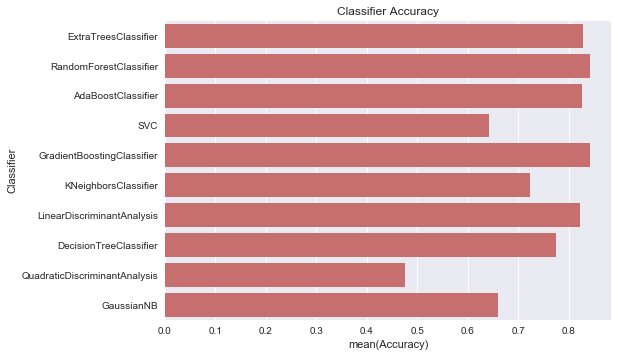

In [7]:
drop_elements = ["PassengerId"]
dtrain = train.drop(drop_elements, axis = 1)
dtest  = test.drop(drop_elements, axis = 1)

train_new=dtrain.values
test_new=dtest.values

classifiers = [
    ExtraTreesClassifier(),
    KNeighborsClassifier(5),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

# SPLIT THE TRAINING DATA UP 10 TIMES AND USE THIS TO ESTIMATE THE TENDENCY TO OVERFIT
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_new
y = target

acc_dict = {}
for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]

	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
# 		acc=f1_score(y_test,train_predictions) # FOR F1 score
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="r")

ikeys=list(acc_dict.keys())
ivals=[]
for i in ikeys:
    ivals.append(acc_dict[i])
for i in np.argsort(ivals):
    print("{:}:{:.0f}%".format(ikeys[i],ivals[i]*100))

    
# USE OPTIMAL CLASSIFIER FOR BEST RESULTS
candidate_classifier=GradientBoostingClassifier()
candidate_classifier.fit(X,y)
y_pred=candidate_classifier.predict(X)
print("Estimated accuracy is {:.1f}%, though this includes overfitting.".format(accuracy_score(y,y_pred)*100))
result = candidate_classifier.predict(test_new)
passengers=test["PassengerId"].values
output=open("GradBoost.csv",'w')
output.write("PassengerId,Survived\n")
for p,r in zip(passengers,result):
    output.write("{:},{:}\n".format(p,int(r)))
output.close()

QuadraticDiscriminantAnalysis:47%
SVC:64%
GaussianNB:66%
KNeighborsClassifier:72%
DecisionTreeClassifier:75%
ExtraTreesClassifier:80%
RandomForestClassifier:80%
AdaBoostClassifier:81%
LinearDiscriminantAnalysis:82%
GradientBoostingClassifier:84%
Estimated accuracy is 94.9%, though this includes overfitting.


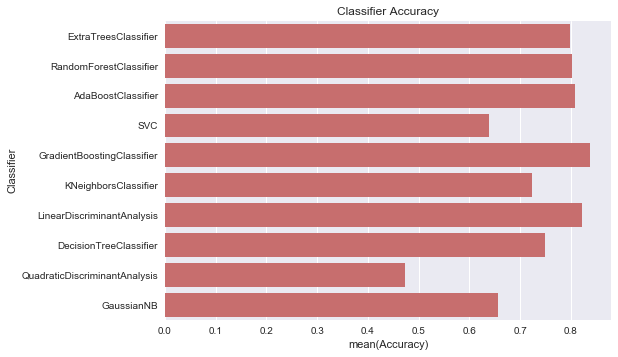

In [8]:
# Alternatively, use PCA to improve feature selection
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

drop_elements = ["PassengerId"]
train,test,target=recover_train_test_target(full)
dtrain = train.drop(drop_elements, axis = 1)
dtest  = test.drop(drop_elements, axis = 1)
train_new=dtrain.values
test_new=dtest.values


clf=PCA()
clf.fit(train_new,target)
good=clf.explained_variance_>1e-5
X=clf.transform(train_new)[:,good]
y = target

classifiers = [
    ExtraTreesClassifier(),
    KNeighborsClassifier(5),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

# SPLIT THE TRAINING DATA UP 10 TIMES AND USE THIS TO ESTIMATE THE TENDENCY TO OVERFIT
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

acc_dict = {}
for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]

	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
# 		acc=f1_score(y_test,train_predictions)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="r")

ikeys=list(acc_dict.keys())
ivals=[]
for i in ikeys:
    ivals.append(acc_dict[i])
for i in np.argsort(ivals):
    print("{:}:{:.0f}%".format(ikeys[i],ivals[i]*100))

    
candidate_classifier=GradientBoostingClassifier()
clf=PCA()
clf.fit(train_new,target)
good=clf.explained_variance_>1e-5
X=clf.transform(train_new)[:,good]
y = target
candidate_classifier.fit(X,y)
y_pred=candidate_classifier.predict(X)
print("Estimated accuracy is {:.1f}%, though this includes overfitting.".format(accuracy_score(y,y_pred)*100))

result = candidate_classifier.predict(clf.transform(test_new)[:,good])
passengers=test["PassengerId"].values
output=open("GradBoost_PCA.csv",'w')
output.write("PassengerId,Survived\n")
for p,r in zip(passengers,result):
    output.write("{:},{:}\n".format(p,int(r)))
output.close()
